In [1]:
from nilearn.image import load_img, new_img_like
from nilearn import plotting
from nilearn.input_data import NiftiMasker
from sklearn.feature_extraction.image import grid_to_graph
import numpy as np
import time
from sklearn.cluster import AgglomerativeClustering
import os
import matplotlib.pyplot as plt


In [2]:
sub_name = "NYU_0051091"
raw_img = load_img("../data/0409/{}_func_minimal.nii.gz".format(sub_name), 1)
print(raw_img.shape)

(61, 73, 61, 176)


In [3]:
flat_img = (raw_img.get_fdata()).reshape(-1,raw_img.shape[3])
flat_img.shape

(271633, 176)

(176, 228453)
{'detrend': False, 'dtype': None, 'high_pass': None, 'low_pass': None, 'mask_args': None, 'mask_img': <nibabel.nifti1.Nifti1Image object at 0x00000253ECAC42C8>, 'mask_strategy': 'background', 'memory': Memory(location=nilearn_cache\joblib), 'memory_level': 1, 'reports': True, 'sample_mask': None, 'sessions': None, 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'target_affine': None, 'target_shape': None, 'verbose': 0}


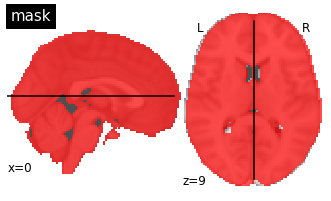

In [4]:
from nilearn.datasets import load_mni152_brain_mask
mask_img = load_mni152_brain_mask()
nifti_masker = NiftiMasker(
    mask_img=mask_img, memory='nilearn_cache', memory_level=1)
nifti_masker = nifti_masker.fit()
flat_img = nifti_masker.transform(raw_img)
print(flat_img.shape)
#mask_img = nifti_masker.mask_img_
plotting.plot_roi(mask_img,title="mask",
                  display_mode='xz',cmap="prism")
print(nifti_masker.get_params())

In [5]:
mask = nifti_masker.mask_img_.get_data().astype(np.bool)
shape = mask.shape
connectivity = grid_to_graph(n_x=shape[0], n_y=shape[1],
                                   n_z=shape[2], mask=mask)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.


In [6]:
spatial_regularisation = 3

# weigh by coords
x_ = np.arange(61)
y_ = np.arange(73)
z_ = np.arange(61)

coords = np.array(np.meshgrid(x_, y_, z_, indexing='ij'))
x,y,z = coords
print(x.shape)
print(y.shape)
print(z.shape)

assert np.all(coords[0,:,0,0] == x_)
assert np.all(coords[1,0,:,0] == y_)
assert np.all(coords[2,0,0,:] == z_)

print(np.array(coords).shape)
out_dir = "../data/0409/{}".format(sub_name)
coods_ni = new_img_like(os.path.join(out_dir, "rena_parcellation.nii.gz"),np.array(coords).T)
flat_coords = nifti_masker.transform(coods_ni)
print(flat_coords.shape)
# normalize
flat_img = (flat_img - flat_img.min()) / (flat_img.max() - flat_img.min())
flat_coords = (flat_coords - flat_coords.min()) / (flat_coords.max() - flat_coords.min())
# add coords to data
input_data = np.vstack((flat_img,spatial_regularisation * flat_coords))
print(input_data.shape)

(61, 73, 61)
(61, 73, 61)
(61, 73, 61)
(3, 61, 73, 61)
(3, 228453)
(179, 228453)


In [19]:
labels

In [16]:
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 200  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                               connectivity=connectivity)
ward.fit(input_data.T)
labels = nifti_masker.inverse_transform(ward.labels_)
print(ward.labels_.shape)
print(labels.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", labels.get_data().size)
print("Number of clusters: ", np.unique(labels.get_data()).size)

Compute structured hierarchical clustering...
(228453,)
(91, 109, 91)
Elapsed time:  96.5049479007721
Number of pixels:  902629
Number of clusters:  200


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  del sys.path[0]


In [8]:
labels.to_filename(os.path.join(out_dir, "skward_reg{}_parcellation.nii.gz".format(spatial_regularisation)))

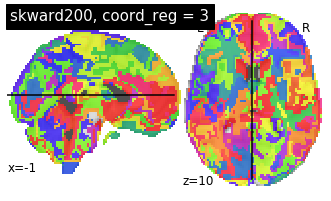

In [9]:
img = plotting.plot_roi(labels ,title="skward200, coord_reg = {}".format(spatial_regularisation),
                  display_mode='xz',cmap="prism")

(91, 109, 91)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show(*args, **kw)>

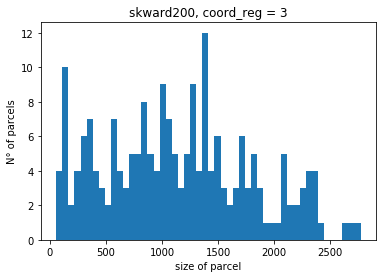

In [12]:
# Histogramme
parcelated_img = load_img(labels, 1)
print(parcelated_img.shape)
data = parcelated_img.get_data()[np.nonzero(parcelated_img.get_data())]
unique, counts = np.unique(data, return_counts=True)

plt.hist(counts,bins=50)
plt.title("skward200, coord_reg = {}".format(spatial_regularisation))
plt.xlabel('size of parcel')
plt.ylabel('N° of parcels')
plt.show

In [15]:
from scipy.sparse import coo_matrix
#get coord adjacency matrix
parcel_submask = []
parcels_size = []
for i in range(n_clusters):
    parcel_submask.append(np.array(np.nonzero(ward.labels_ == i))[0])
    parcels_size.append(len(parcel_submask[-1]))
A = np.zeros([n_clusters, n_clusters])
ward_connectivity = ward.connectivity.tocsr()
for i in range(n_clusters):
    for j in range(i):
        a = ward_connectivity[parcel_submask[i],:][:,parcel_submask[j]]
        A[i,j] = a.sum()
        A[j,i] = A[i,j]
    A[A!=0] = 1
print(A)

[[0. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
print(ward)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<228453x228453 sparse matrix of type '<class 'numpy.int32'>'
	with 1564939 stored elements in COOrdinate format>,
                        distance_threshold=None, linkage='ward', memory=None,
                        n_clusters=200)


In [ ]:
masked_clusters = nifti_masker.transform(clustered_img)
plotting.plot_roi(masked_clusters,title="masked skward200 parcellation",
                  display_mode='xz',cmap="prism")

In [23]:
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 200  # number of regions
ward_no_conectivity = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
ward_no_conectivity.fit(flat_img)
label_no_conectivity = np.reshape(ward_no_conectivity.labels_, raw_img.shape[0:3])
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label_no_conectivity.size)
print("Number of clusters: ", np.unique(label_no_conectivity).size)

Compute structured hierarchical clustering...


MemoryError: Unable to allocate 275. GiB for an array with shape (36892107528,) and data type float64

In [7]:
wards = load_img(
        os.path.join(out_dir, "skward_reg{}_parcellation.nii.gz".format(spatial_regularisation))
        )

In [25]:
ward_data = wards.get_fdata()
print(ward_data[ward_data!=0])
print(ward_data.shape)
pos = np.where(ward_data == 10)
listOfCoordinates= np.array(list(zip(pos[0], pos[1], pos[2])))
print(listOfCoordinates)

[28. 28. 28. ...  3.  3.  3.]
(91, 109, 91)
[[22 24 18]
 [22 24 19]
 [22 24 20]
 ...
 [58 19 17]
 [59 19 16]
 [59 19 17]]
